# Markov Random Field For Image Segmentation and Denoising
This project has two parts. In part one, we use a Markov random field Model to denoise an image. In Part two, we use a similar model for image segmentation. 

## Part 1
In this part, we have an image. We add a gussian noise to it. Then we use markov model

    Import Libraries

In [11]:
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import random

### Original Image


(1848, 1848)
initial image


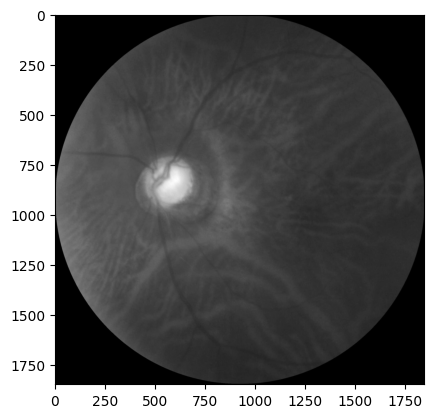

In [16]:
path = 'REFUGE2/Test/refuge2-test/T0001.jpg'
arr = imageio.imread(path, mode='L')
print(arr.shape)
labels = imageio.imread("REFUGE2/Test/Disc_Mask/T0001.png", mode='L')
print ("initial image")
imshow(arr, cmap='gray')

mask image
[  0 128 255]


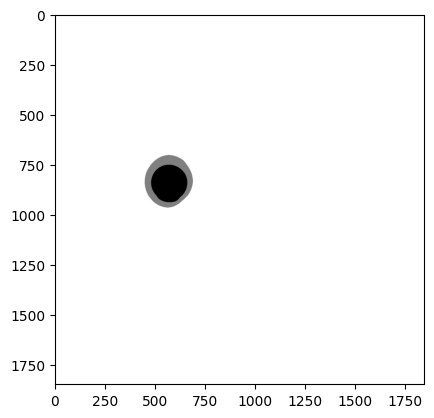

In [22]:
print("mask image")
imshow(labels, cmap='gray')
print(np.unique(labels))

In [4]:
tmp = plt.gcf().clear()

<Figure size 640x480 with 0 Axes>

## Part A
In this part we added noise (with normal distribution) to the image.

### Make Noisy Image

In [5]:
def add_noise (arr, var):
    noise = np.random.normal(0, np.sqrt(var), arr.shape)
    noisy_arr = arr + noise
    return noisy_arr

### Learn Noise Distribution 


In [ ]:
def naive_bayes_learning(arr, noisy_arr, labels):
    class_info = []
    number_of_pixels = arr.size
    for cls in [0,128,255]:
        tmp = []
        for i in range(0, len(arr)):
            for j in range(0, len(arr[0])):
                if (labels[i][j]==cls):
                    tmp.append(noisy_arr[i][j])
        tmp = np.asarray(tmp)
        class_mean = np.mean(tmp)
        class_var = np.var(tmp)
        class_freq = len(tmp)
        class_probabilty = class_freq/number_of_pixels
        class_info.append([class_probabilty, class_mean, class_var])
    return class_info

    Normal PDF

In [7]:
def pdf_of_normal(x, mean=0, var=1):
    return (1/np.sqrt(2 *  np.pi * var))*np.exp(-((x-mean)**2)/(2*var))

### Naive Bayes Classifier
We used naive bayes classifier for predicting the real label of each pixel

In [8]:
def naive_bayes_predict (arr, class_info, fixed_pixels_index=[], correct_arr = []):
    predict_array = np.zeros((len(arr), len(arr[0])), dtype=float)
    class_color = [0,127,255]
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])): 
            if (len(fixed_pixels_index)>0 and len(correct_arr)>0 and fixed_pixels_index[i][j]==1):
                predict_array[i][j]=correct_arr[i][j]
                continue
            max_probabilty = 0
            best_class = -1
            val = arr[i][j]
            for cls_index in range(len(class_info)):
                cls_p =  class_info[cls_index][0]
                mean =  class_info[cls_index][1]
                var = class_info[cls_index][2]
                pos =pdf_of_normal(val, mean, var)
                cls_posterior = cls_p * pos

                if (cls_posterior > max_probabilty):
                    max_probabilty = cls_posterior
                    best_class = cls_index
            
            predict_array[i][j] = class_color[best_class]
            
    return predict_array

## Part B
In this part, we used Naive Bayes classifier defined in part A to classify true labels for each of the image's pixels.

d:\Probablistic Reasoning\EndSem\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Probablistic Reasoning\EndSem\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Probablistic Reasoning\EndSem\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Probablistic Reasoning\EndSem\.venv\Lib\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Probablistic Reasoning\EndSem\.venv\Lib\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Noisy Image with var 0


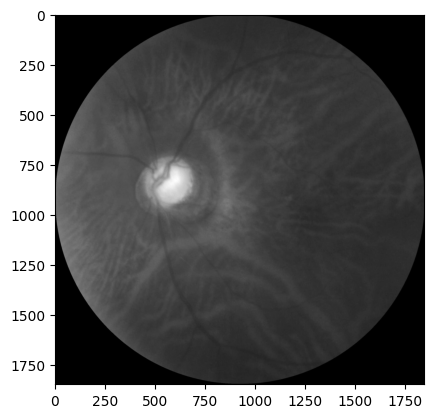

Naive Bayes Classifier Labels


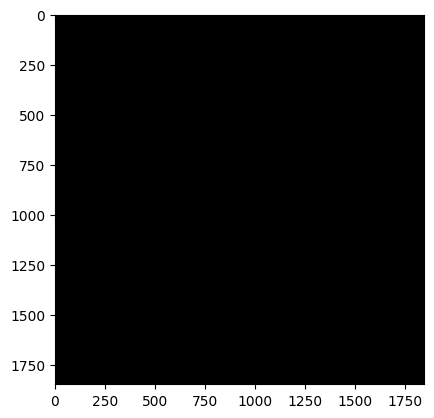

Noisy Image with var 100


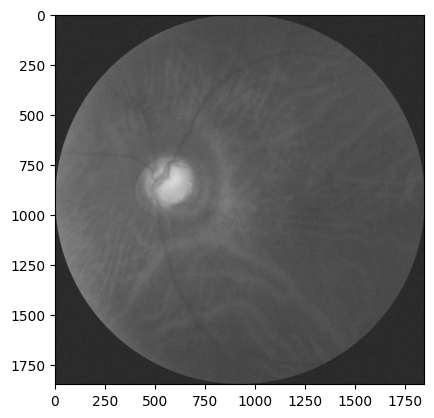

Naive Bayes Classifier Labels


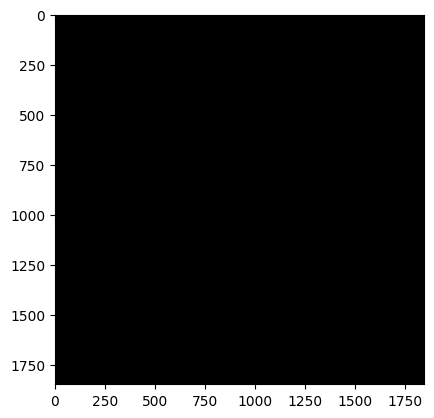

Noisy Image with var 1000


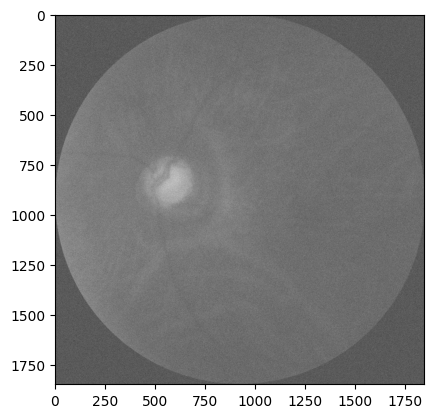

Naive Bayes Classifier Labels


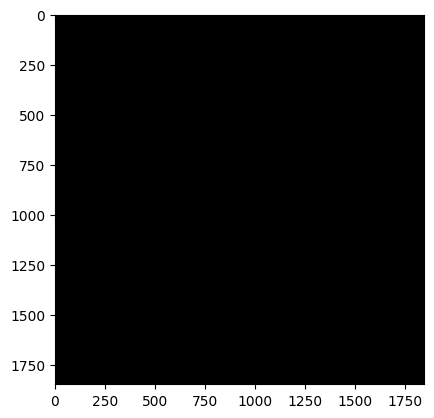

Noisy Image with var 20000


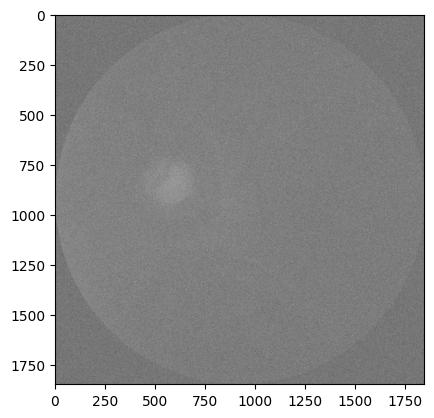

Naive Bayes Classifier Labels


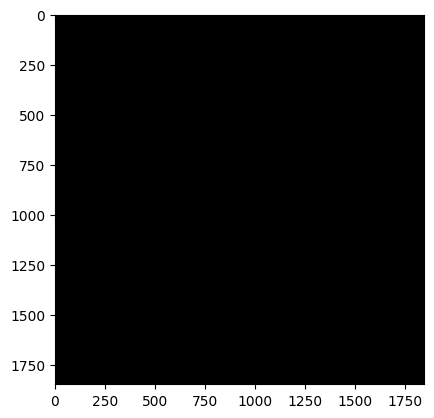

In [23]:
variance_list = [0, 100, 1000, 20000]
for var in variance_list:
    noisy_arr = add_noise(arr, var)
    cls_info = naive_bayes_learning(arr, noisy_arr, labels)
    prediciton_array = naive_bayes_predict(noisy_arr, cls_info)
    print ("Noisy Image with var", var)
    plt.imshow(noisy_arr, cmap='gray')
    plt.show()
    print ("Naive Bayes Classifier Labels")
    plt.imshow(prediciton_array, cmap='gray')
    plt.show()

As you can see the results, this approach worked well when the noise variance is 10, but when the noise increases, this approach didn't work well.

## Party C

Markov Random Field Models provide a simple and effective way to model the spatial dependencies in image pixels. <br>
So we useed them to model the connection between two neighbour pixels. <br>
In our problem we have to define an energy function on hidden states corresponding to true values of each pixels, then we minimize this function to obtain the best prediction. <br>
Our energy function is defined as below: <br>
 

$U(w)=\sum_{s} (\lg (\sigma_{\omega_{s}} \sqrt{2 \pi}) + \frac{(f_s - \mu_{\omega_{s}})^2}{2(\sigma_{\omega_{s}})^2}) + \sum_{s,r} \beta \delta (s,r)  $

In [24]:
def distance (x,y):
    a = x-y
    a = a*a
    return np.sqrt(np.sum(a))

In [25]:
def difference(a,b):
    if (a==b):
        return -1
    else:
        return 1

In [26]:
def initial_energy_function(initial_w, pixels, betha, cls_info, neighbors_indices):
    w = initial_w
    energy = 0.0
    rows = len(w)
    cols = len(w[0])
    for i in range(0, len(w)):
        for j in range(0, len(w[0])):
            mean = cls_info[int (w[i][j])][1]
            var =  cls_info[int (w[i][j])][2]
            energy += np.log(np.sqrt(2*np.pi*var)) 
            energy += ((pixels[i][j]-mean)**2)/(2*var)
            for a,b in neighbors_indices:
                a +=i
                b +=j
                if 0<=a<rows and 0<=b<cols:
                    energy += betha * difference(w[i][j], w[a][b])
    return energy

In [27]:
def exponential_schedule(step_number, current_t, initial_temp,  constant=0.99):
    return current_t*constant
def logarithmical_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * np.log(1+step_number))
def linear_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * step_number)

In [28]:
def delta_enegry(w, index, betha, new_value, neighbors_indices, pixels, cls_info):
    initial_energy = 0 
    (i,j) = index
    rows = len(w)
    cols = len(w[0])
    mean = cls_info[int(w[i][j])][1]
    var =  cls_info[int(w[i][j])][2]
    initial_energy += np.log(np.sqrt(2*np.pi*var)) 
    initial_energy += ((pixels[i][j]-mean)**2)/(2*var)
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            initial_energy += betha * difference(w[i][j], w[a][b])
    
    new_energy = 0
    mean = cls_info[new_value][1]
    var =  cls_info[new_value][2]
    new_energy += np.log(np.sqrt(2*np.pi*var)) 
    new_energy += ((pixels[i][j]-mean)**2)/(2*var)
    # print("/////// \n first enegry", new_energy)

    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            new_energy += betha * difference(new_value, w[a][b])

    # print ("END energy", new_energy)

    return new_energy - initial_energy

In [29]:
def simulated_annealing(init_w, class_labels, temprature_function,
                        pixels, betha, cls_info, neighbors_indices, max_iteration=10000,
                        initial_temp = 1000, known_index=[], correct_arr = [], temprature_function_constant=None ):
    partial_prediction=False
    if (len(known_index)>0 and len(correct_arr)>0):
        partial_prediction=True

    w = np.array(init_w)
    changed_array = np.zeros((len(w), len(w[0])))
    iteration =0
    x = len(w)
    y = len(w[0])
    current_energy = initial_energy_function(w, pixels, betha, cls_info, neighbors_indices)
    current_tmp = initial_temp
    while (iteration<max_iteration):
        if (partial_prediction):
            is_found=False
            while (is_found==False):
                i = random.randint(0, x-1)
                j = random.randint(0, y-1)
                if (known_index[i][j]==0):
                    is_found=True
        else:
            i = random.randint(0, x-1)
            j = random.randint(0, y-1)

        l = list(class_labels)
        l.remove(w[i][j])
        r = random.randint(0, len(l)-1)
        new_value = l[r]
        delta = delta_enegry(w, (i,j), betha, new_value, neighbors_indices, pixels, cls_info)

        r = random.uniform(0, 1)

        if (delta<=0):
            w[i][j]=new_value
            current_energy+=delta
            changed_array[i][j]+=1
            # print ("CHANGED better")
        else:
            try:
                if (-delta / current_tmp < -600):
                    k=0
                else:
                    k = np.exp(-delta / current_tmp)
            except:
                k=0

            if r < k:
                # print("CHANGED worse")
                w[i][j] = new_value
                current_energy += delta
                changed_array[i][j] += 1
        if (temprature_function_constant!=None):
            current_tmp = temprature_function(iteration, current_tmp, initial_temp, constant =temprature_function_constant)
        else:
            current_tmp = temprature_function(iteration, current_tmp, initial_temp)
        iteration+=1
    return w, changed_array

In [30]:
def convert_to_class_labels(arr, inverse_array={0:0, 127:1, 255:2}):
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            arr[i][j] = inverse_array[int(arr[i][j])]

In [31]:
def get_accuracy(arr, labels):
    correct = 0
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            if (labels[i][j]==int(arr[i][j]/127)):
                correct+=1
    return correct/(len(arr[0])*len(arr))

In [32]:
# plt.close('all')
def a_complete_set_for_part_1 (arr, max_iter=1000000,var = 10000,
                               betha = 100,
                               neighbor_indices = [[0,1],[0,-1],[1,0],[-1,0]],
                               class_labels = [0,1,2], 
                               class_color = [0,127,255], 
                               schedule= exponential_schedule,
                               temprature_function_constant=None):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#     fig.suptitle('Comparision', fontsize=20)
    
    noisy_arr = add_noise(arr, var)
    ax1.set_title('Noisy image \n accuracy '+str(get_accuracy(noisy_arr, labels)))

    ax1.imshow(noisy_arr, cmap='gray')


    rows = len(noisy_arr)
    cols = len(noisy_arr[0])

    cls_info = naive_bayes_learning(arr, noisy_arr, labels)

    initial_arr = naive_bayes_predict(noisy_arr, cls_info)
    ax2.set_title('Naive Bayes image \n accuracy '+str(get_accuracy(initial_arr, labels)))
    ax2.imshow(initial_arr, cmap='gray')

    convert_to_class_labels(initial_arr)
    
    w, test_array = simulated_annealing(initial_arr, class_labels, schedule,
                                        noisy_arr, betha, cls_info, neighbor_indices, max_iteration=max_iter)

    
    for i in range (0, len(w)):
        for j in range(0, len(w[0])):
            w[i][j] = class_color[int (w[i][j])]

    ax3.set_title('CRF image \n accuracy '+str(get_accuracy(w, labels)))
    ax3.imshow(w, cmap='gray')
    plt.rcParams["figure.figsize"] = (20,3)


    ax4.set_title('differ image')

    ax4.imshow(test_array, cmap='gray')

    plt.show()

## Part D
We used naive bayes results of __Part B__ as the initial state for the true pixels values. Then we used simulated annealing optimization method. We tested different hyper pararmeters to compare the performance of the MRF models with  naive bayes model. <br>

In [33]:
plt.figure(figsize=(10, 12), dpi=80, facecolor='w', edgecolor='k')

<Figure size 800x960 with 0 Axes>

<Figure size 800x960 with 0 Axes>

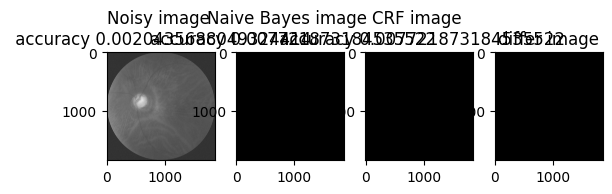

In [34]:
a_complete_set_for_part_1(arr, max_iter=1e4, var=1e2, betha=1e2)

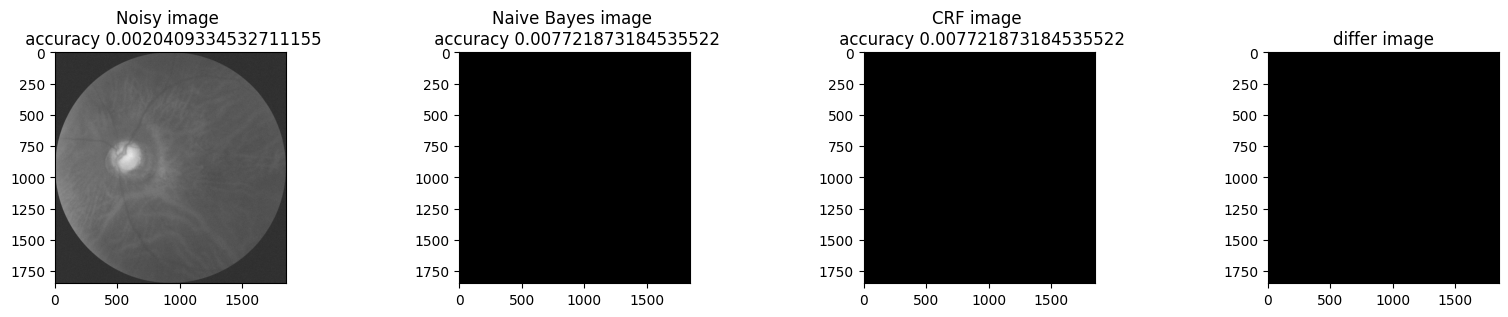

In [35]:
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=1e2)

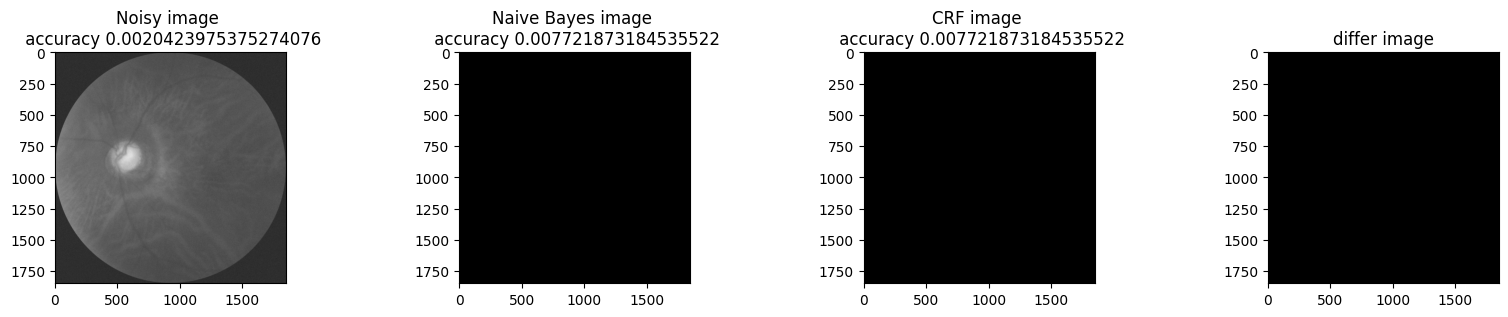

In [36]:
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=1e4)

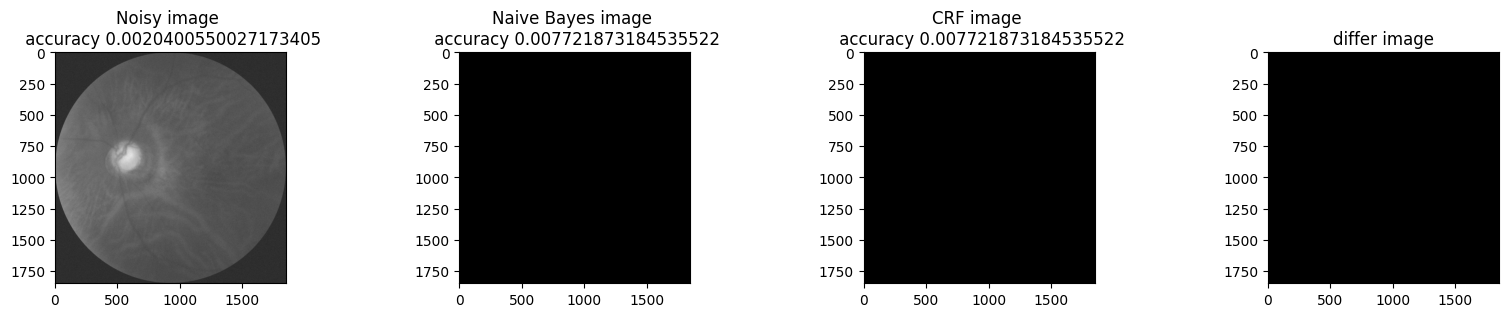

In [37]:
a_complete_set_for_part_1(arr, max_iter=1e7, var=1e2, betha=1e4)

## Part E
We compared two different modes. First mode uses only four neighbors pixels. Second mode uses eight neighbors pixels in the model. The result is as below.

### Model with four neighbors

<Figure size 800x960 with 0 Axes>

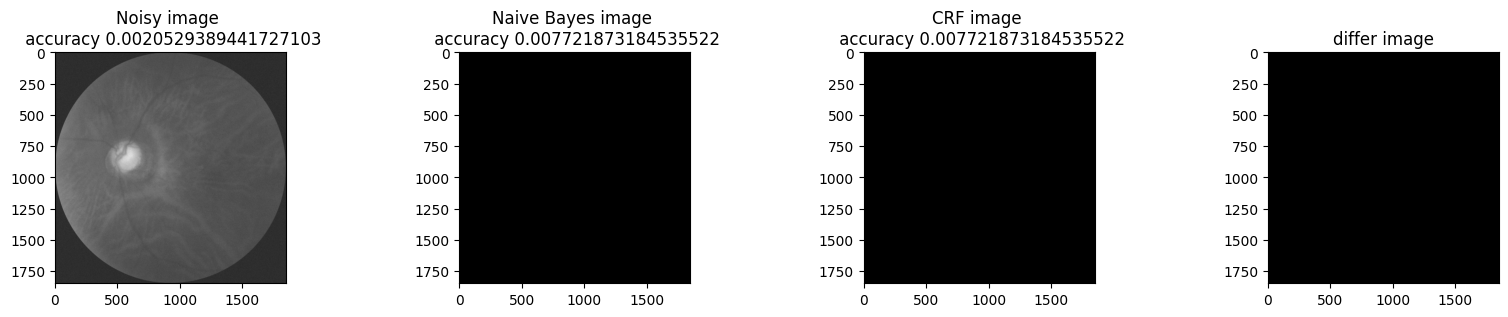

In [38]:
plt.figure(figsize=(10, 12), dpi=80, facecolor='w', edgecolor='k')
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=1e4)

### Model with eight neighbors

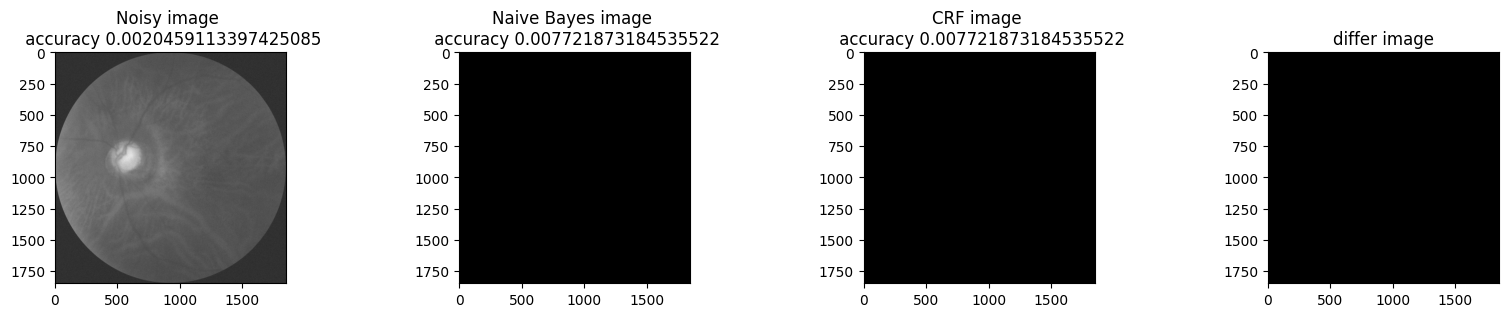

In [39]:
eight_neighbors_indices =  [[0,1],[0,-1],[1,0],[-1,0],[1,1],[1,-1],[-1,1],[-1,-1]]
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=1e4, neighbor_indices=eight_neighbors_indices)

### Comparision
When we used eight neighbours, the smoothness of result increased. The weakness of eight neighbors parameter is that the model can't find a good boundary for the circle in the center. Because circles border are different from rectangles and so the number of same color in the border of circle is less than rectangles border. And the model connot predict well in this situation. If we use lower betha, then the result for the circle is going to be better.

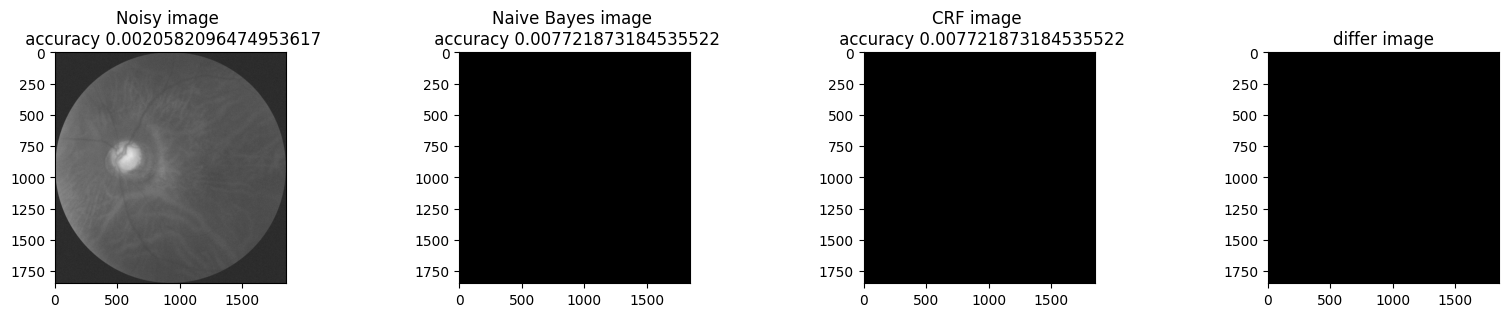

In [40]:
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=1e-1, neighbor_indices=eight_neighbors_indices)

## Part F
In this part, we tested different  $\beta$ as the hyperparameter. And the result is as follow.

Betha 0.0001


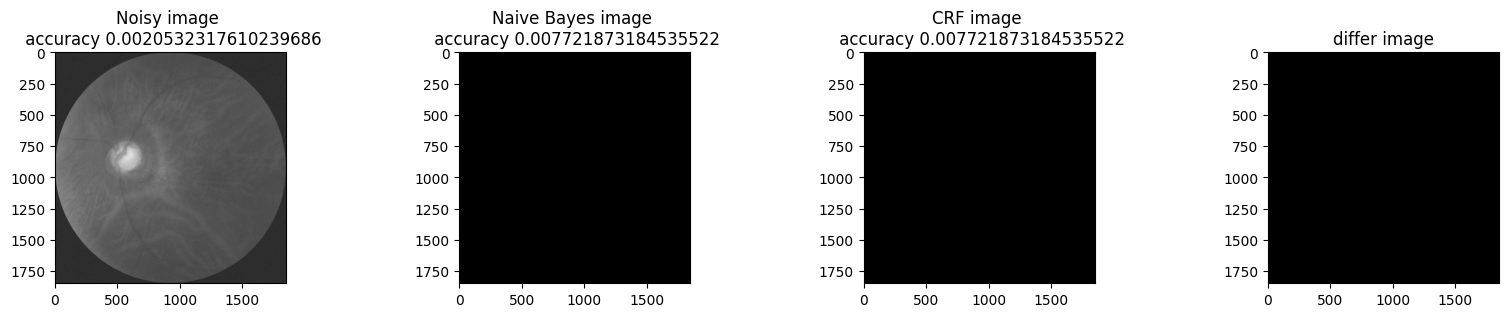

In [41]:
bta = 1e-4
print ("Betha", bta)
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=bta)

Betha 0.001


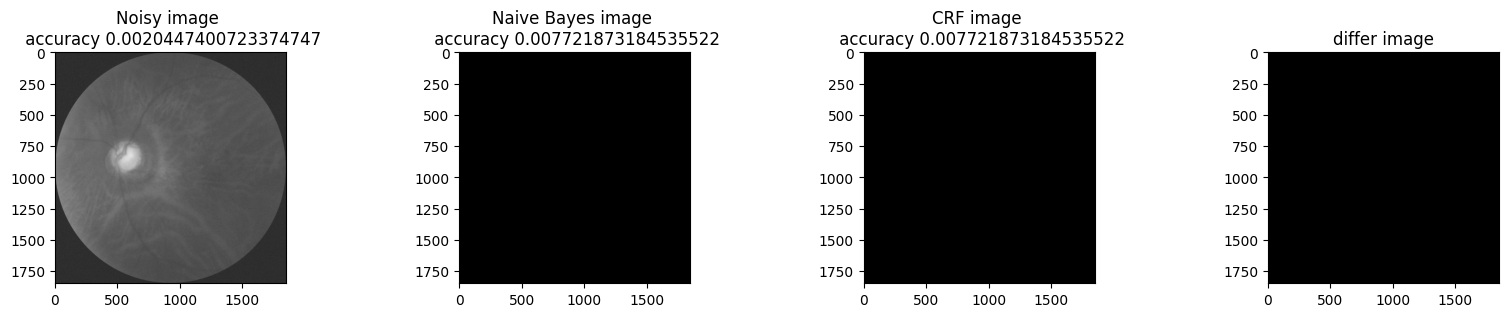

In [42]:
bta = 1e-3
print ("Betha", bta)
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=bta)

Betha 0.01


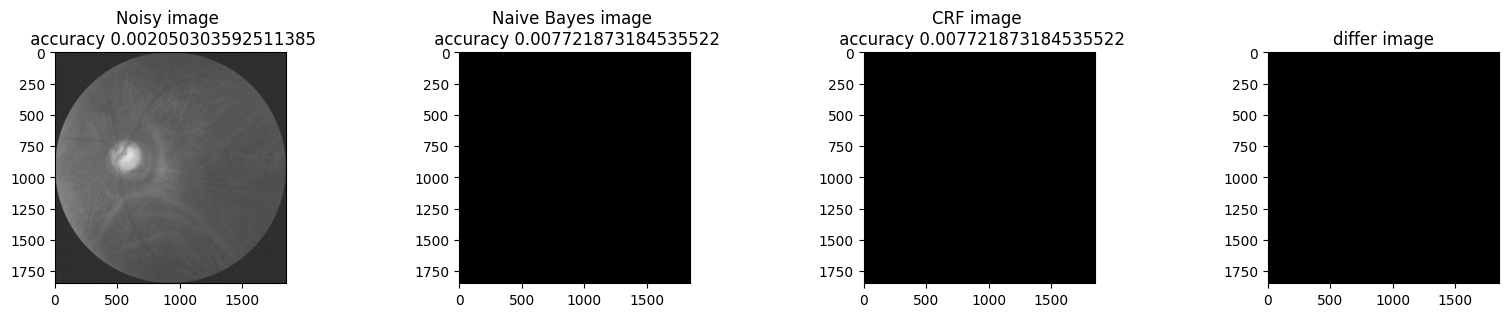

In [43]:
bta = 1e-2
print ("Betha", bta)
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=bta)

Betha 0.1


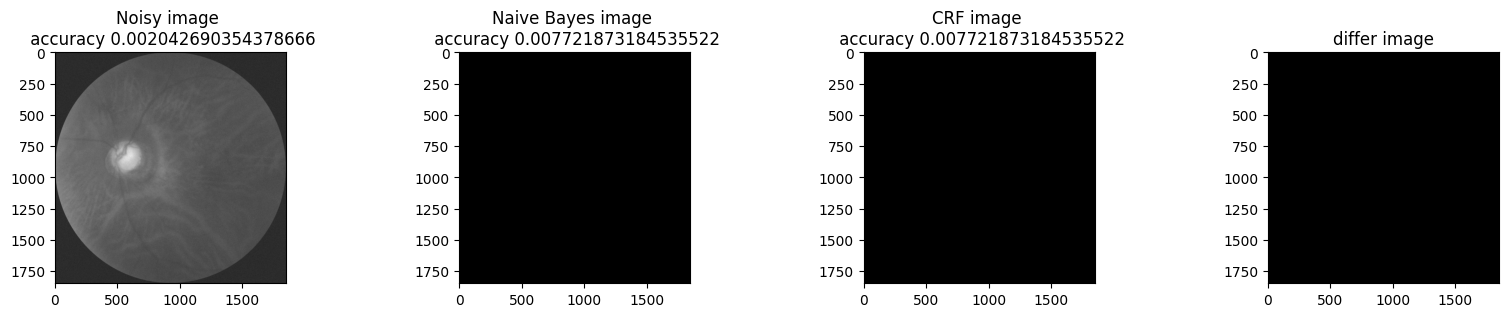

In [44]:
bta = 1e-1
print ("Betha", bta)
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=bta)

Betha 1.0


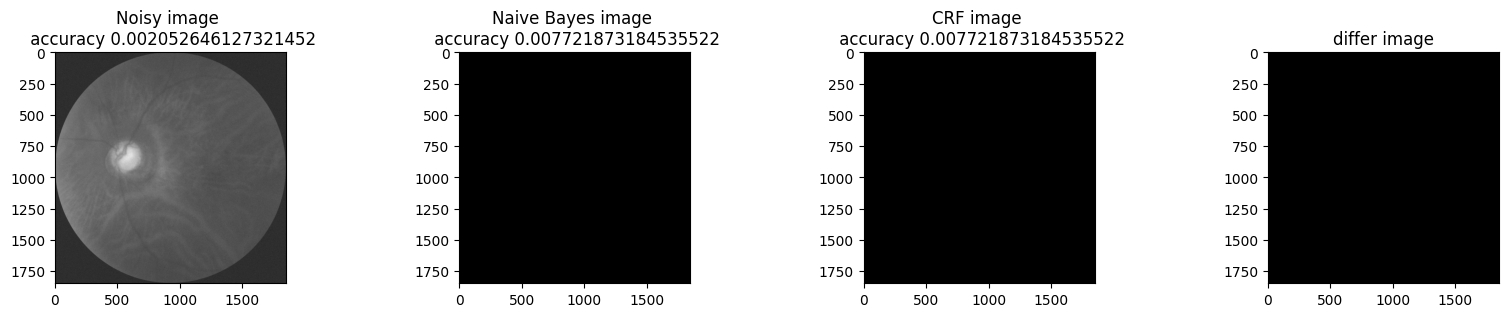

In [45]:
bta = 1e0
print ("Betha", bta)
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=bta)

Betha 10.0


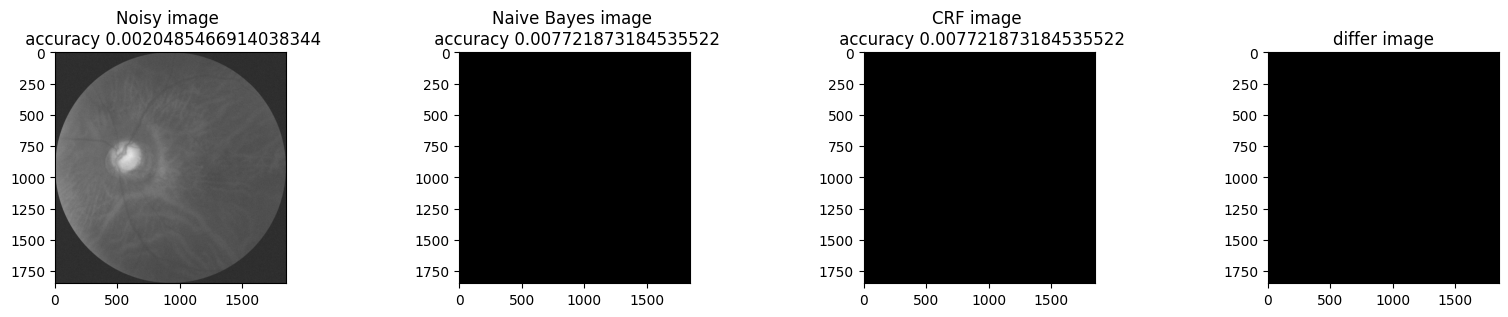

In [46]:
bta = 1e1
print ("Betha", bta)
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=bta)

Betha 100.0


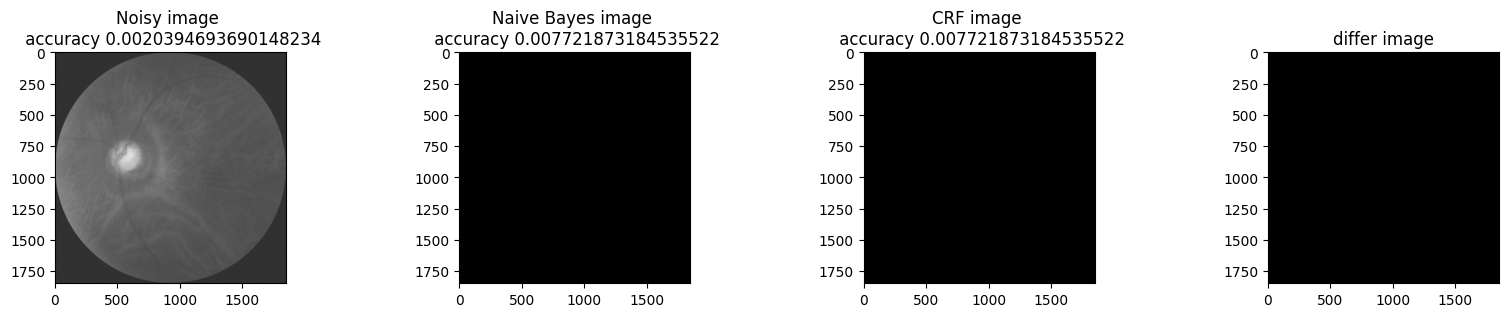

In [47]:
bta = 1e2
print ("Betha", bta)
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=bta)

Betha 10000.0


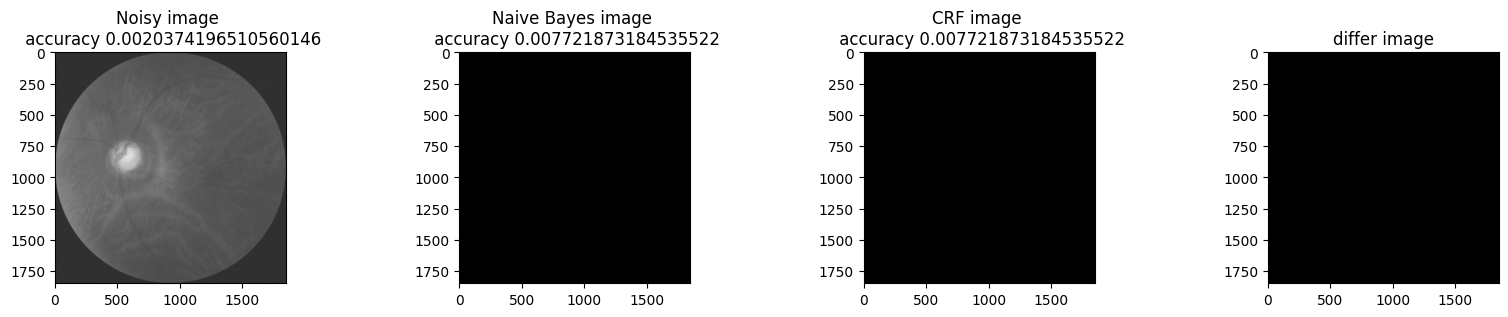

In [48]:
bta = 1e4
print ("Betha", bta)
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=bta)

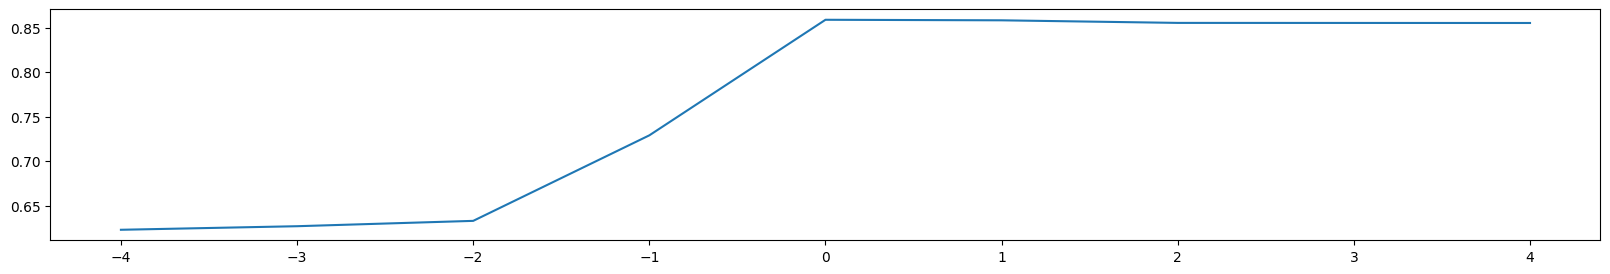

In [49]:
xs = [-4,-3,-2,-1,0,1,2,4]
accs = [0.623, 0.627, .633, .729, .8587, .8581, .8552, .8551]
plt.plot(xs, accs)
plt.show()

According to the above graph, the best $\beta$ is 1e0=1.

## Part G
In this part, we have some part of the image and we want to predict the remaining part. 

In [50]:
def a_complete_set_for_part_1_some_pixels_known (arr,known_index, max_iter=1000000,var = 10000,
                               betha = 100,
                               neighbor_indices = [[0,1],[0,-1],[1,0],[-1,0]],
                               class_labels = [0,1,2],
                               class_color = [0,127,255],
                               schedule= exponential_schedule
                            ,temprature_function_constant=None):


    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#     fig.suptitle('Comparision', fontsize=20)

    noisy_arr = add_noise(arr, var)
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            if (known_index[i][j]==1):
                noisy_arr[i][j]=arr[i][j]

    ax1.set_title('Noisy image \n accuracy '+str(get_accuracy(noisy_arr, labels)))

    ax1.imshow(noisy_arr, cmap='gray')


    rows = len(noisy_arr)
    cols = len(noisy_arr[0])

    cls_info = naive_bayes_learning(arr, noisy_arr, labels)

    initial_arr = naive_bayes_predict(noisy_arr, cls_info, fixed_pixels_index=known_index, correct_arr = arr)
    ax2.set_title('Naive Bayes image \n accuracy '+str(get_accuracy(initial_arr, labels)))
    ax2.imshow(initial_arr, cmap='gray')

    convert_to_class_labels(initial_arr)

    w, test_array = simulated_annealing(initial_arr, class_labels, schedule,
                                        noisy_arr, betha, cls_info, neighbor_indices,
                                        max_iteration=max_iter, known_index=known_index, correct_arr=arr)


    for i in range (0, len(w)):
        for j in range(0, len(w[0])):
            w[i][j] = class_color[int (w[i][j])]

    ax3.set_title('CRF image \n accuracy '+str(get_accuracy(w, labels)))
    ax3.imshow(w, cmap='gray')
    plt.rcParams["figure.figsize"] = (20,3)


    ax4.set_title('differ image')

    ax4.imshow(test_array, cmap='gray')

    plt.show()

KeyError: 1

<Figure size 800x960 with 0 Axes>

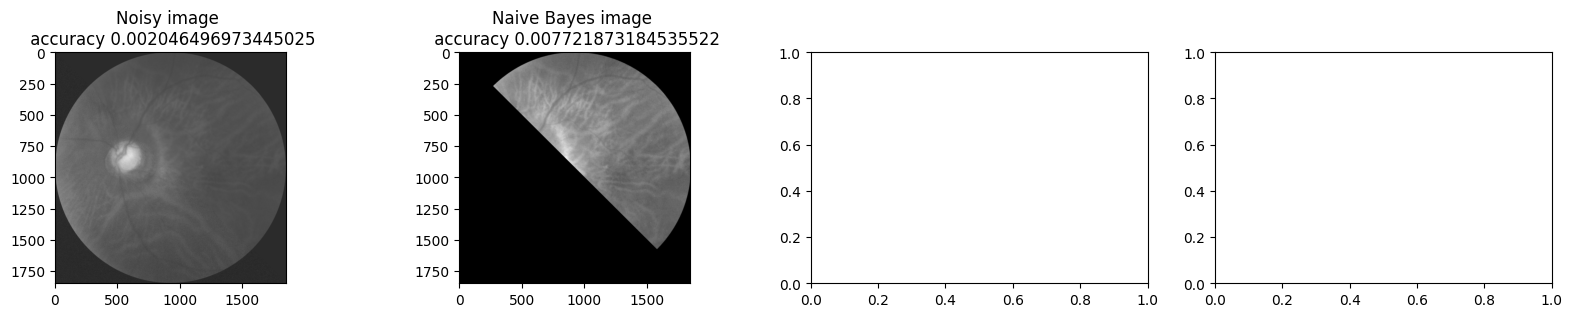

In [51]:
plt.figure(figsize=(10, 12), dpi=80, facecolor='w', edgecolor='k')
known_index = np.zeros((len(arr), len(arr[0])))
for i in range (0, len(arr)):
    for j in range(0, len(arr[0])):
        if (i <= j ):
            known_index[i][j]=1
bta = 1e4
a_complete_set_for_part_1_some_pixels_known(arr,  known_index, max_iter=1e6, var=1e2, betha=bta)

## Part H
In this part, we compared different schedules in simulated annealing optimizer.<br>
We tested different scheduling Strategy. And the result is as follow.

#### Exponential Schedule

In [ ]:
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=bta,
                          schedule=exponential_schedule, temprature_function_constant=0.8)

In [ ]:
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=bta,
                          schedule=exponential_schedule, temprature_function_constant=0.9)

#### Logarithmical Multiplicative Cooling Schedule

In [ ]:
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=bta,
                          schedule=logarithmical_multiplicative_cooling_schedule, temprature_function_constant=1.0)

#### Linear Multiplicative Cooling Schedule

In [ ]:
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=bta,
                          schedule=linear_multiplicative_cooling_schedule, temprature_function_constant=1.0)

In [ ]:
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=bta,
                          schedule=linear_multiplicative_cooling_schedule, temprature_function_constant=0.5)

In [ ]:
a_complete_set_for_part_1(arr, max_iter=1e6, var=1e2, betha=bta,
                          schedule=linear_multiplicative_cooling_schedule, temprature_function_constant=1.5)

## Part 2
In this part, we used Markov Random Field for image segmentation.
<br>
We used different image color space:
- Gray Scale
- HSV
- RGB Format

In [ ]:
from PIL import Image
import numpy as np
from scipy import misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import random
import imageio

### Orginal Image

In [ ]:
path = "REFUGE2/Test/refuge2-test/T0001.jpg"
arr = imageio.imread(path, mode='L')
print ("initial image")
imshow(arr, cmap='gray')

In [ ]:
tmp = plt.gcf().clear()


### Gray Scale

    Getting labels from training data

In [ ]:
initial_probability = {"Sky.jpg": 0.30,"Road.jpg": 0.20, "Grass.jpg":0.50}
number_of_pixels = arr.size
class_info = []
paths= ["Sky.jpg", "Road.jpg", "Grass.jpg"]
for path in paths:
    tmp_arr = misc.imread(path, flatten=True)
    class_mean = np.mean(tmp_arr)
    class_var = np.var(tmp_arr)
    class_freq = len(tmp_arr)
    class_probabilty = class_freq/number_of_pixels
    class_info.append([initial_probability[path], class_mean, class_var])

print ("class_info")
print (class_info)

    Normal PDF

In [ ]:
def pdf_of_normal(x, mean, var):
    return (1/np.sqrt(2 *  np.pi * var))*np.exp(-((x-mean)**2)/(2*var))

### Naive Bayes Classifier
We used naive bayes classifier for predicting the real label of each pixel

In [ ]:
def naive_bayes_predict (arr, class_info, fixed_pixels_index=[], correct_arr = []):
    predict_array = np.zeros((len(arr), len(arr[0])), dtype=float)
    class_color = [0,127,255]
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])): 
            if (len(fixed_pixels_index)>0 and len(correct_arr)>0 and fixed_pixels_index[i][j]==1):
                predict_array[i][j]=correct_arr[i][j]
                continue
            max_probabilty = 0
            best_class = -1
            val = arr[i][j]
            for cls_index in range(len(class_info)):
                cls_p =  class_info[cls_index][0]
                mean =  class_info[cls_index][1]
                var = class_info[cls_index][2]
                pos =pdf_of_normal(val, mean, var)
                cls_posterior = cls_p * pos

                if (cls_posterior > max_probabilty):
                    max_probabilty = cls_posterior
                    best_class = cls_index
            
            predict_array[i][j] = class_color[best_class]
            
    return predict_array

In [ ]:
def distance (x,y):
    a = x-y
    a = a*a
    return np.sqrt(np.sum(a))

In [ ]:
def difference(a,b):
    if (a==b):
        return -1
    else:
        return 1

In [ ]:
def initial_energy_function(initial_w, pixels, betha, cls_info, neighbors_indices):
    w = initial_w
    energy = 0.0
    rows = len(w)
    cols = len(w[0])
    for i in range(0, len(w)):
        for j in range(0, len(w[0])):
            mean = cls_info[int (w[i][j])][1]
            var =  cls_info[int (w[i][j])][2]
            energy += np.log(np.sqrt(2*np.pi*var)) 
            energy += ((pixels[i][j]-mean)**2)/(2*var)
            for a,b in neighbors_indices:
                a +=i
                b +=j
                if 0<=a<rows and 0<=b<cols:
                    energy += betha * difference(w[i][j], w[a][b])
    return energy

In [ ]:
def exponential_schedule(step_number, current_t, initial_temp,  constant=0.99):
    return current_t*constant
def logarithmical_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * np.log(1+step_number))
def linear_multiplicative_cooling_schedule(step_number, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * step_number)

In [ ]:
def delta_enegry(w, index, betha, new_value, neighbors_indices, pixels, cls_info):
    initial_energy = 0 
    (i,j) = index
    rows = len(w)
    cols = len(w[0])
    mean = cls_info[int(w[i][j])][1]
    var =  cls_info[int(w[i][j])][2]
    initial_energy += np.log(np.sqrt(2*np.pi*var)) 
    initial_energy += ((pixels[i][j]-mean)**2)/(2*var)
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            initial_energy += betha * difference(w[i][j], w[a][b])
    
    new_energy = 0
    mean = cls_info[new_value][1]
    var =  cls_info[new_value][2]
    new_energy += np.log(np.sqrt(2*np.pi*var)) 
    new_energy += ((pixels[i][j]-mean)**2)/(2*var)
    # print("/////// \n first enegry", new_energy)

    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            new_energy += betha * difference(new_value, w[a][b])

    # print ("END energy", new_energy)

    return new_energy - initial_energy

In [ ]:
def simulated_annealing(init_w, class_labels, temprature_function,
                        pixels, betha, cls_info, neighbors_indices, max_iteration=10000,
                        initial_temp = 1000, known_index=[], correct_arr = [], temprature_function_constant=None ):
    partial_prediction=False
    if (len(known_index)>0 and len(correct_arr)>0):
        partial_prediction=True

    w = np.array(init_w)
    changed_array = np.zeros((len(w), len(w[0])))
    iteration =0
    x = len(w)
    y = len(w[0])
    current_energy = initial_energy_function(w, pixels, betha, cls_info, neighbors_indices)
    current_tmp = initial_temp
    while (iteration<max_iteration):
        if (partial_prediction):
            is_found=False
            while (is_found==False):
                i = random.randint(0, x-1)
                j = random.randint(0, y-1)
                if (known_index[i][j]==0):
                    is_found=True
        else:
            i = random.randint(0, x-1)
            j = random.randint(0, y-1)

        l = list(class_labels)
        l.remove(w[i][j])
        r = random.randint(0, len(l)-1)
        new_value = l[r]
        delta = delta_enegry(w, (i,j), betha, new_value, neighbors_indices, pixels, cls_info)

        r = random.uniform(0, 1)

        if (delta<=0):
            w[i][j]=new_value
            current_energy+=delta
            changed_array[i][j]+=1
            # print ("CHANGED better")
        else:
            try:
                if (-delta / current_tmp < -600):
                    k=0
                else:
                    k = np.exp(-delta / current_tmp)
            except:
                k=0

            if r < k:
                # print("CHANGED worse")
                w[i][j] = new_value
                current_energy += delta
                changed_array[i][j] += 1
        if (temprature_function_constant!=None):
            current_tmp = temprature_function(iteration, current_tmp, initial_temp, constant =temprature_function_constant)
        else:
            current_tmp = temprature_function(iteration, current_tmp, initial_temp)
        iteration+=1
    return w, changed_array

In [ ]:
def convert_to_class_labels(arr, inverse_array={0:0, 127:1, 255:2}):
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            arr[i][j] = inverse_array[int(arr[i][j])]

In [ ]:
def get_accuracy(arr, labels):
    correct = 0
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            if (labels[i][j]==int(arr[i][j]/127)):
                correct+=1
    return correct/(len(arr[0])*len(arr))

In [ ]:
# plt.close('all')
def a_complete_set_for_part_2 (arr, class_info, max_iter=1000000,var = 10000,
                               betha = 100,
                               neighbor_indices = [[0,1],[0,-1],[1,0],[-1,0]],
                               class_labels = [0,1,2], 
                               class_color = [0,127,255], 
                               schedule= exponential_schedule,
                               temprature_function_constant=None):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#     fig.suptitle('Comparision', fontsize=20)
    

    ax1.set_title("initial image")

    ax1.imshow(arr, cmap='gray')


    rows = len(arr)
    cols = len(arr[0])

#     cls_info = naive_bayes_learning(arr, noisy_arr, labels)
    cls_info = class_info
    initial_arr = naive_bayes_predict(arr, cls_info)
    ax2.set_title('Naive Bayes image')
    ax2.imshow(initial_arr, cmap='gray')

    convert_to_class_labels(initial_arr)
    
    w, test_array = simulated_annealing(initial_arr, class_labels, schedule,
                                        arr, betha, cls_info, neighbor_indices, max_iteration=max_iter)

    
    for i in range (0, len(w)):
        for j in range(0, len(w[0])):
            w[i][j] = class_color[int (w[i][j])]

    ax3.set_title('CRF image')
    ax3.imshow(w, cmap='gray')
    plt.rcParams["figure.figsize"] = (20,3)
    ax4.set_title('differ image')

    ax4.imshow(test_array, cmap='gray')

    
    plt.show()

In [ ]:
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')

In [ ]:
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')
a_complete_set_for_part_2(arr,class_info, max_iter=1e4, betha=1e4)

In [ ]:
a_complete_set_for_part_2(arr,class_info, max_iter=1e4, betha=1e6)

In [ ]:
a_complete_set_for_part_2(arr,class_info, max_iter=1e6, betha=1e6)

In [ ]:
a_complete_set_for_part_2(arr,class_info, max_iter=1e7, betha=1e6)

### HSV color space

Now we want to use HSV color space for training our data.

In [ ]:
import matplotlib
path = "test2-mini.jpg"
img = Image.open(path)
hsv_arr = matplotlib.colors.rgb_to_hsv(img)
hsv_arr = np.asarray(hsv_arr)
h_arr = hsv_arr[:,:,0]
plt.imshow(h_arr, cmap="gray")
plt.show()

In [ ]:
def read_image_h(path):
    img = Image.open(path)
    hsv_arr = matplotlib.colors.rgb_to_hsv(img)
    hsv_arr = np.asarray(hsv_arr)
    h_arr = hsv_arr[:,:,0]
#     plt.imshow(h_arr, cmap="gray")
#     plt.show()
    return 256*h_arr

In [ ]:
initial_probability = {"Sky.jpg": 0.30,"Road.jpg": 0.20, "Grass.jpg":0.50}
number_of_pixels = arr.size
class_info = []
paths= ["Sky.jpg", "Road.jpg", "Grass.jpg"]
for path in paths:
    tmp_arr = read_image_h(path)
    class_mean = np.mean(tmp_arr)
    class_var = np.var(tmp_arr)
    class_freq = len(tmp_arr)
    class_probabilty = class_freq/number_of_pixels
    class_info.append([initial_probability[path], class_mean, class_var])

print ("class_info")
print (class_info)

In [ ]:
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')

In [ ]:
arr_h = read_image_h("test2-mini.jpg")

In [ ]:
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')
a_complete_set_for_part_2(arr_h,class_info, max_iter=1e2, betha=1e4)

In [ ]:
a_complete_set_for_part_2(arr_h,class_info, max_iter=1e4, betha=1e4)

In [ ]:
a_complete_set_for_part_2(arr_h,class_info, max_iter=1e6, betha=1e4)

In [ ]:
a_complete_set_for_part_2(arr_h,class_info, max_iter=1e6, betha=1e6)

### RGB color space
In this part, we used RGB color format in training since there is some information that can be captured by pixels colors.<br> 
We used RGB values in potential function.

In [ ]:
def get_class_info_color(img_path, color_index,
                         paths=["Sky.jpg", "Road.jpg", "Grass.jpg"],
                         initial_probability={"Sky.jpg": 0.30,"Road.jpg": 0.20, "Grass.jpg":0.50}):
    arr_general = misc.imread(img_path)
    arr = arr_general[:,:,color_index]
    number_of_pixels = arr.size
    class_info = []
    paths= ["Sky.jpg", "Road.jpg", "Grass.jpg"]
    for path in paths:
        tmp_arr = misc.imread(path)
        tmp_arr = tmp_arr[:,:,color_index]
        class_mean = np.mean(tmp_arr)
        class_var = np.var(tmp_arr)
        class_freq = len(tmp_arr)
        # class_probabilty = class_freq/number_of_pixels
        class_info.append([initial_probability[path], class_mean, class_var])

    return class_info

In [ ]:
def naive_bayes_predict_3_color (arr, class_infos, fixed_pixels_index=[], correct_arr = []):
    predict_array = np.zeros((len(arr), len(arr[0])), dtype=float)
    class_color = [0,127,255]
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])): 
            if (len(fixed_pixels_index)>0 and len(correct_arr)>0 and fixed_pixels_index[i][j]==1):
                predict_array[i][j]=correct_arr[i][j]
                continue
            max_probabilty = 0
            best_class = -1
            
            for cls_index in range(0, len(class_color)):
                cls_posterior = class_infos[0][cls_index][0]
                for c in range(0, 3):#for RGB
                    val = arr[i][j][c]
                    class_info = class_infos[c]
                    mean =  class_info[cls_index][1]
                    var = class_info[cls_index][2]
                    pos =pdf_of_normal(val, mean, var)
                    cls_posterior *= pos
                    
                
                if (cls_posterior > max_probabilty):
                    max_probabilty = cls_posterior
                    best_class = cls_index     

            
            predict_array[i][j] = class_color[best_class]
            
    return predict_array

In [ ]:
def initial_energy_function_colored(initial_w, pixels, betha, cls_infos, neighbors_indices):
    w = initial_w
    energy = 0.0
    rows = len(w)
    cols = len(w[0])
    for i in range(0, len(w)):
        for j in range(0, len(w[0])):
            for c in [0,1,2]:
                cls_info = cls_infos[c]
                mean = cls_info[int (w[i][j])][1]
                var =  cls_info[int (w[i][j])][2]
                pixel_value = pixels[i][j][c]
                energy += np.log(np.sqrt(2*np.pi*var)) 
                energy += ((pixel_value-mean)**2)/(2*var)
            for a,b in neighbors_indices:
                a +=i
                b +=j
                if 0<=a<rows and 0<=b<cols:
                    energy += betha * difference(w[i][j], w[a][b])
    return energy

In [ ]:
def delta_enegry_colored(w, index, betha, new_value, neighbors_indices, pixels, cls_infos):
    initial_energy = 0 
    (i,j) = index
    rows = len(w)
    cols = len(w[0])
    for c in [0,1,2]:
        cls_info = cls_infos[c]
        mean = cls_info[int(w[i][j])][1]
        var =  cls_info[int(w[i][j])][2]
        pixel_value = pixels[i][j][c]
        initial_energy += np.log(np.sqrt(2*np.pi*var)) 
        initial_energy += ((pixel_value-mean)**2)/(2*var)
        
    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            initial_energy += betha * difference(w[i][j], w[a][b])
    
    new_energy = 0
    for c in [0,1,2]:
        cls_info = cls_infos[c]
        mean = cls_info[new_value][1]
        var =  cls_info[new_value][2]
        pixel_value = pixels[i][j][c]
        new_energy += np.log(np.sqrt(2*np.pi*var)) 
        new_energy += ((pixel_value-mean)**2)/(2*var)
    # print("/////// \n first enegry", new_energy)

    for a,b in neighbors_indices:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<cols:
            new_energy += betha * difference(new_value, w[a][b])

    # print ("END energy", new_energy)

    return new_energy - initial_energy

In [ ]:
def simulated_annealing_colored(init_w, class_labels, temprature_function,
                        pixels, betha, cls_infos, neighbors_indices, max_iteration=10000,
                        initial_temp = 1000, known_index=[], correct_arr = [], temprature_function_constant=None ):
    partial_prediction=False
    if (len(known_index)>0 and len(correct_arr)>0):
        partial_prediction=True
    
    w = np.array(init_w)
    changed_array = np.zeros((len(w), len(w[0])))
    iteration =0
    x = len(w)
    y = len(w[0])
    current_energy = initial_energy_function_colored(w, pixels, betha, cls_infos, neighbors_indices)
    current_tmp = initial_temp
    while (iteration<max_iteration):
        if (partial_prediction):
            is_found=False
            while (is_found==False):
                i = random.randint(0, x-1)
                j = random.randint(0, y-1)
                if (known_index[i][j]==0):
                    is_found=True
        else:
            i = random.randint(0, x-1)
            j = random.randint(0, y-1)

        l = list(class_labels)
        l.remove(w[i][j])
        r = random.randint(0, len(l)-1)
        new_value = l[r]
        delta = delta_enegry_colored(w, (i,j), betha, new_value, neighbors_indices, pixels, cls_infos)

        r = random.uniform(0, 1)

        if (delta<=0):
            w[i][j]=new_value
            current_energy+=delta
            changed_array[i][j]+=1
            # print ("CHANGED better")
        else:
            try:
                if (-delta / current_tmp < -600):
                    k=0
                else:
                    k = np.exp(-delta / current_tmp)
            except:
                k=0

            if r < k:
                # print("CHANGED worse")
                w[i][j] = new_value
                current_energy += delta
                changed_array[i][j] += 1
        if (temprature_function_constant!=None):
            current_tmp = temprature_function(iteration, current_tmp, initial_temp, constant =temprature_function_constant)
        else:
            current_tmp = temprature_function(iteration, current_tmp, initial_temp)
        iteration+=1
    return w, changed_array

In [ ]:
def a_complete_set_for_part_2_3_color (max_iter=1000000, var = 10000,
                               betha = 100,
                               neighbor_indices = [[0,1],[0,-1],[1,0],[-1,0]],
                               class_labels = [0,1,2],
                               class_color = [0,127,255],
                               schedule= exponential_schedule,
                               temprature_function_constant=None,
                               image_path = "test2-mini.jpg"):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#     fig.suptitle('Comparision', fontsize=20)

    arr = misc.imread(image_path)
    ax1.set_title("initial image")

    ax1.imshow(arr)




#     cls_info = naive_bayes_learning(arr, noisy_arr, labels)
    cls_infos = []
    for c in [0,1,2]:
        tmp_info =get_class_info_color(image_path,c)
        cls_infos.append(tmp_info)


    initial_arr = naive_bayes_predict_3_color(arr, cls_infos)
    ax2.set_title('Naive Bayes image')
    ax2.imshow(initial_arr, cmap='gray')

    
    convert_to_class_labels(initial_arr)

    w, test_array = simulated_annealing_colored(initial_arr, class_labels, schedule,
                                        arr, betha, cls_infos, neighbor_indices, max_iteration=max_iter)


    for i in range (0, len(w)):
        for j in range(0, len(w[0])):
            w[i][j] = class_color[int (w[i][j])]

    ax3.set_title('CRF image')
    ax3.imshow(w, cmap='gray')
    plt.rcParams["figure.figsize"] = (20,3)
    ax4.set_title('differ image')

    ax4.imshow(test_array, cmap='gray')

In [ ]:
a_complete_set_for_part_2_3_color(max_iter=1e2, betha=1e4)

In [ ]:
a_complete_set_for_part_2_3_color(max_iter=1e4, betha=1e4)

In [ ]:
a_complete_set_for_part_2_3_color(max_iter=1e6, betha=1e4)

In [ ]:
a_complete_set_for_part_2_3_color(max_iter=1e6, betha=1e6)

In [ ]:
a_complete_set_for_part_2_3_color(max_iter=1e6, betha=1e6,
                                 schedule=linear_multiplicative_cooling_schedule, temprature_function_constant=0.5)

In [ ]:
np.seterr(all='raise');
a_complete_set_for_part_2_3_color(max_iter=1e6, betha=1e6,
                                 schedule=linear_multiplicative_cooling_schedule, temprature_function_constant=0.5)

## Conclusion
Grayscale image format didn't have sufficient information for CRF models in this task.<br>
The value H in HSV image format had better information for segmentation using CRF models. And the result was better. <br>
The RGB format also had good information for segmenting the image. Because these three segments have different colors. So if a CRF model considers colors of the image for classification, then the result is going to be better compared to Grayscale images.